# Demo notebook

First we import the libraries we need

In [1]:
# Standard imports
import sys
import numpy as np
import matplotlib.pyplot as plt

# Third-party imports
import camb # Calculates the linear matter power spectrum

# Halo Model library imports
sys.path.append('../src')
import halomodel as halo

Now we set the cosmological parameters. If `sigma_8_set = True` we scale the linear power spectrum to account for the new `sigma_8` value.  

In [2]:
# Set cosmological parameters
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h = 0.7
As = 2e-9
ns = 0.96
w = -1.0
wa = 0.0
m_nu = 0.0 # [eV]
sigma_8_set = True # If True uses the following value
sigma_8  = 0.7

Set some plot parameters

In [3]:
# Plot colours
col_lin = 'grey'
col_mat = 'C0'
col_gal = 'C1'
col_cen = 'C3'
col_sat = 'C0'
col_mg  = 'C4'
col_cs  = 'C5'

# Plot line styles
ls_li = '-'
ls_hm = '-'
ls_2h = '--'
ls_1h = ':'

# Plot labels
klab = r'$k\,/\,h \mathrm{Mpc}^{-1}$'
Pklab = r'$P(k)/(h^{-1}\,\mathrm{Mpc})^3$'

Now let's set some parameters that we will use throughout the calculation: First, we set a range of wavenumbers, `k`, and then fill array, `ks`, we then set a redshift, `z`.

In [4]:
# Wavenumber range [h/Mpc]
kmin = 1e-3; kmax = 10.
nk = 101
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Redshift
z = 0.

# CAMB
zmax_CAMB = 2.
kmax_CAMB = 200.

Now we initialise `CAMB` and produce a linear matter power spectrum. We have the option here to scale the power by an input `sigma_8` value.

In [5]:
# Sets cosmological parameters in camb to calculate the linear power spectrum
pars = camb.CAMBparams()
wb   = Omega_b*h**2
wc   = Omega_c*h**2

# This function sets standard and helium set using BBN consistency
pars.set_cosmology(ombh2=wb, omch2=wc, H0=100.*h, mnu=m_nu, omk=Omega_k)
pars.set_dark_energy(w=w, wa=wa, dark_energy_model='ppf') 
pars.InitPower.set_params(As=As, ns=ns, r=0.)
pars.set_matter_power(redshifts=[z], kmax=kmax_CAMB) # Setup the linear matter power spectrum

# Scale 'As' to be correct for the desired 'sigma_8' value if necessary
if sigma_8_set:
    camb_results = camb.get_results(pars)
    sigma_8_init = (camb_results.get_sigma8()[[z].index(0.)]).item()
    print('Initial sigma_8:', sigma_8_init)
    scaling = (sigma_8/sigma_8_init)**2
    As *= scaling
    pars.InitPower.set_params(As=As, ns=ns, r=0.)

# Now get the linear power spectrum
Pk_lin = camb.get_matter_power_interpolator(pars, 
                                            nonlinear=False, 
                                            hubble_units=True, 
                                            k_hunit=True, 
                                            kmax=kmax,
                                            var1=camb.model.Transfer_tot,
                                            var2=camb.model.Transfer_tot, 
                                            zmax=zmax_CAMB,
                                           )
Omega_m  = pars.omegam # Also extract the matter density
Pk_lin = Pk_lin.P # Single out the linear P(k) interpolator
camb_results = camb.get_results(pars)
if sigma_8_set: 
    sigma_8 = (camb_results.get_sigma8()[[z].index(0.)]).item()
    print('Final sigma_8:', sigma_8)


Initial sigma_8: 0.8051557239194955
Final sigma_8: 0.6999999999999998


Now we can create a halo model, which needs to be reinitialised at each different redshift. In this example notebook we are only doing calculations at a single redshift, so we initialise the halo model with that in mind. We also need to choose a mass function and linear halo bias, in this example these come from `Tinker et al. (2010)`, and we need to choose a halo definition, here we choose $\Delta_\mathrm{v}=330$, so haloes are defined to be spherical objects that contain an average density that is $330$ times greater than the mean background universe, which is approximately the virial (spherical-collapse) definition for this cosmology at $z=0$.

In [6]:
# Initialise halo model
hmod = halo.model(z, Omega_m, name='Tinker et al. (2010)', Dv=330.)
print(hmod)

Halo model: Tinker et al. (2010)
Scale factor: 1.000
Redshift: 0.000
Omega_m(z=0): 0.300
delta_c: 1.6860
Delta_v: 330.0
Parameters:
alpha: 0.370; beta: 0.571; gamma: 0.944; phi: -0.829; eta: -0.261
A: 1.001; a: 0.228
B: 0.183; b: 1.500
C: 0.289; c: 2.400



Now we set a range of halo masses, `M`, and fill an array, `Ms`. This halo-mass range needs to be wide enough that it includes all 'interesting' halo masses from the point of view of the calculation, and the mass-spacing needs to be fine enough that the calculation converges; in an actual use-case the effect on power spectra of both mass range and spacing should be convergence tested. Then we find the Lagrangian radii, `Rs`, corresponding the the halo masses.

In [7]:
# Halo mass range [Msun/h] over which to integrate
Mmin = 1e9; Mmax = 1e17
nM = 256
Ms = np.logspace(np.log10(Mmin), np.log10(Mmax), nM)

# Lagrangian radii [Mpc/h] corresponding to halo masses
Rs = hmod.Lagrangian_radius(Ms)

Next, we need to get an array of `sigma(R)` values. This requires an integral over the linear power spectrum times the Fourier transform of a top hat function, which is the oscillatory sinc function. We can get this from `CAMB`.

In [8]:
# Get sigma(R) from CAMB
sigmaRs = camb_results.get_sigmaR(Rs, hubble_units=True, return_R_z=False)[0]

Now we can plot $\sigma(R)$, note that the variance in the linear density field is larger when smoothing is performed at smaller scales (smaller values of $R$), as one would expect. Also note how boring and featureless this function is, despite the (relative) feature-full-ness of the linear spectrum.

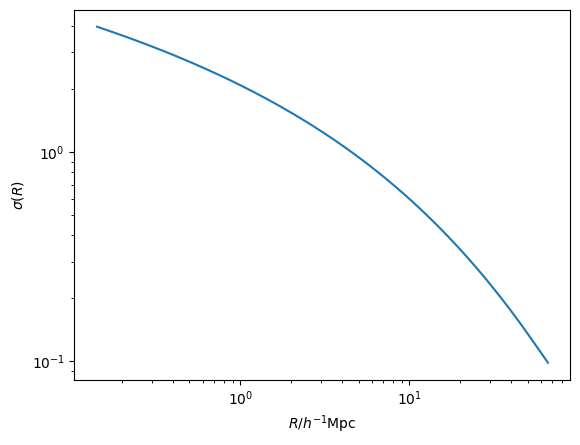

In [9]:
# Plot sigma(R)
plt.loglog(Rs, sigmaRs)
plt.xlabel(r'$R/h^{-1}\mathrm{Mpc}$')
plt.ylabel(r'$\sigma(R)$')
plt.show()

Now lets plot the dimensionless multiplicity function, $M^2 n(M)/\bar\rho$, as a function of halo mass for three popular halo mass functions: Sheth & Tormen (1999); Tinker et al. (2010); Despali et al. (2016) for the virial halo definition. Note that the `kmax_CAMB` value for `Pk_lin` is important here. We chose `kmax_CAMB=200`, which produces smooth functions. A smaller `kmax_CAMB` can produce noisy results for lower masses, and this can go on to spoil some halo-power power spectrum predictions.

In [10]:
# List of mass functions to consider
mass_functions = [
    'Sheth & Tormen (1999)',
    'Tinker et al. (2010)',
    'Despali et al. (2016)',
]

# Calculate b(M) and n(M)
bs = []
Fs = []
for _mass_function in mass_functions:
    print(_mass_function)#, 'z = %1.1f'%(z))
    hmod = halo.model(z, Omega_m, name=_mass_function, Dv=330.)
    b = hmod.linear_bias(Ms, sigmas=sigmaRs)
    F = hmod.multiplicity_function(Ms, sigmas=sigmaRs)
    bs.append(b)
    Fs.append(F)

Sheth & Tormen (1999)
Tinker et al. (2010)
Despali et al. (2016)


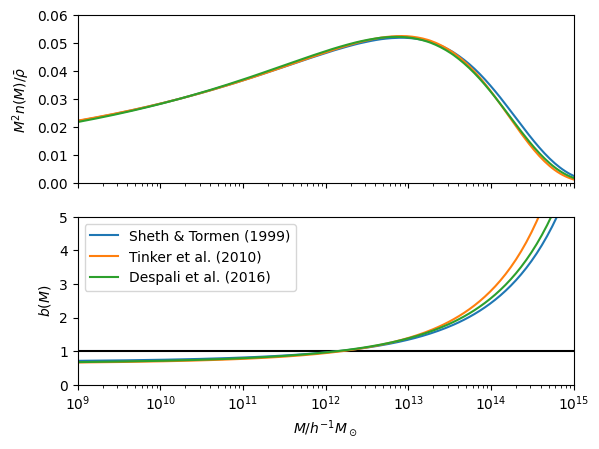

In [11]:
# Plot parameters
Mmin_plot, Mmax_plot = 1e9, 1e15

# Make the plot
plt.subplots(2, 1)

# Mass function
plt.subplot(2, 1, 1)
for i, _ in enumerate(mass_functions):
    plt.plot(Ms, Fs[i], ls='-', color='C%d'%i)
plt.xscale('log')
plt.gca().set_xticklabels([])
plt.ylim((0., 0.06))
plt.ylabel(r'$M^2 n(M)/\bar\rho$')
plt.xlim((Mmin_plot, Mmax_plot))

# Linear bias
plt.subplot(2, 1, 2)
plt.axhline(1., color='black')
for i, _mass_function in enumerate(mass_functions):
    plt.plot(Ms, bs[i], ls='-', color='C%d'%i, label=_mass_function)
plt.xlabel(r'$M / h^{-1} M_\odot$')
plt.xscale('log')
plt.ylim((0., 5.))
plt.ylabel(r'$b(M)$')
plt.xlim((Mmin_plot, Mmax_plot))
plt.legend()

# Finalize
plt.show()

From the upper plot, which can be interpreted as a probability density function for  we infer that the most important haloes will be $\sim10^{13}h^{-1}M_\odot$, but that there is a long tail of halo mass down to low masses.

First, we will use the halo model to compute the matter power spectrum, to do this we need to define a matter halo. We use the `haloprof` class, which contains the Fourier window function of the halo profile `W(M,k)` that is necessary for the power-spectrum calculation. This is a 2D array of the window function evaluated at `(ks, Ms)` values defined above, so if these change then the `haloprof` must be updated. We break the function $W(M,k)=N(M)U(M,k)/{\rm norm}$ where $W(M,k)$ has dimensions of field multiplied by volume, $N(M)/{\rm norm}$ has dimension of field multiplied by volume and $U(M,k)$ is dimensionless and should tend to unity as k tends to zero, because its real space counter part is normalised. 

In our case, we are going to compute the power spectrum of matter overdensity (density contrast: $\delta_{\rm m}=(\rho-\bar\rho)/\bar\rho$), which is dimensionless. We take $N(M)=M$, ${\rm norm}=\bar\rho$, such that $N(M)/{\rm norm}$ = $M/\bar\rho$ and has dimensions of volume. We could also have set $N(M)=M/\bar\rho$ and ${\rm norm}=1$ and would get the same results. The distinction between these two approaches is important for discrete tracers, but not otherwise.

We also need to set the optional `mass_tracer=True` in the halo profile, to let it know that our profile corresponds to a matter profile. This is important because the contribution to the matter power of haloes below `Mmin`, set above, is important to the calculation (much of the mass in the Universe is in very low mass haloes), and this flag allows this to be taken into account in a consistent way.

In [12]:
# Halo window functions
rvs = hmod.virial_radius(Ms)
cs = halo.concentration(Ms, z, method='Duffy et al. (2008)', halo_definition='Mvir') # Specify 'Mvir' for Duffy c(M)
Uk = halo.window_function(ks, rvs, cs, profile='NFW')

# Initialise profile class
matter_profile = halo.profile.Fourier(ks, Ms, Uk, amp=Ms, norm=hmod.rhom, mass_tracer=True) # Need mass_tracer=True here
print(matter_profile)

Halo profile
Mass tracer: True
Discrete tracer: False
Field normalisation: 83262006415.74907
Number of wavenumber bins: 101
Number of mass bins: 256
Wavenumber range [log10(h/Mpc)]: -3.000 1.000
Halo mass range [log10(Msun/h)]: 9.000 17.000
The following are at the low and high halo mass ends
Profile amplitude mean [log10]: 9.0 17.0
Dimensionless profiles at low k (should be ~1): 0.99999999998453 0.9999950419099892
Dimensionful profiles at low k (should be amplitudes): 0.012010279874727825 1201022.032686495



Now we are in a position to combine our halo model with our matter profile and do a calculation of the power spectrum. Note that profile must be provided as a dictionary: `{'m': matter_profile}` rather than `matter_profile`, where the key `'m'` can be chosen by the user and identifies that the `matter_profile` corresponds to field `'m'`. The reason for this will become apparent soon.

In [13]:
# Calculate the halo-model power spectrum
Pk_2h, Pk_1h, Pk_hm = hmod.power_spectrum(ks, Ms, {'m': matter_profile}, sigmas=sigmaRs, Pk_lin=lambda k: Pk_lin(z, k))

Now let's do some plotting. Note carefully that the output arrays `Pk_2h`, `Pk_1h`, and `Pk_hm` are three dimensional, with `k` in the third dimension. In this first example the first two dimensions are length `1` because we have only provided one profile, the `matter_profile`. So to access the power spectrum we need `Pk_xx['m-m']`.

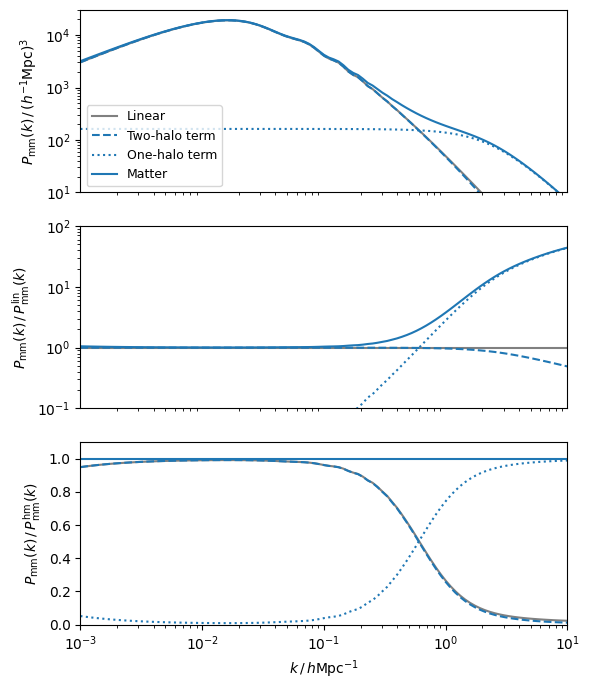

In [14]:
# Initialise plot
plt.subplots(3, 1, figsize=(6., 7.), dpi=100)
Pkmin = 1e1; Pkmax = 3e4
rmin = 1e-1; rmax = 1e2
smin = 0.0; smax = 1.1
kmin_plot = 1e-3; kmax_plot = 1e1

# P(k)
plt.subplot(3, 1, 1)
plt.loglog(ks, Pk_lin(z, ks), color=col_lin, label='Linear')
plt.loglog(ks, Pk_2h['m-m'], color=col_mat, ls=ls_2h, label='Two-halo term')
plt.loglog(ks, Pk_1h['m-m'], color=col_mat, ls=ls_1h, label='One-halo term')
plt.loglog(ks, Pk_hm['m-m'], color=col_mat, ls=ls_hm, label='Matter')
plt.xticks([])
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_\mathrm{mm}(k)\,/\,(h^{-1} \mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.legend(fontsize='9', loc='lower left')

# Residual with linear
plt.subplot(3, 1, 2)
plt.loglog(ks, Pk_lin(z, ks)/Pk_lin(z, ks), color=col_lin)
plt.loglog(ks, Pk_2h['m-m']/Pk_lin(z, ks), color=col_mat, ls=ls_2h)
plt.loglog(ks, Pk_1h['m-m']/Pk_lin(z, ks), color=col_mat, ls=ls_1h)
plt.loglog(ks, Pk_hm['m-m']/Pk_lin(z, ks), color=col_mat, ls=ls_hm)
plt.xticks([])
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_\mathrm{mm}(k)\,/\,P^\mathrm{lin}_{\rm mm}(k)$')
plt.ylim((rmin, rmax))

# Residual with halo-model matter power
plt.subplot(3, 1, 3)
plt.semilogx(ks, Pk_lin(z, ks)/Pk_hm['m-m'], color=col_lin, ls='-')
plt.semilogx(ks, Pk_2h['m-m']/Pk_hm['m-m'], color=col_mat, ls=ls_2h)
plt.semilogx(ks, Pk_1h['m-m']/Pk_hm['m-m'], color=col_mat, ls=ls_1h)
plt.semilogx(ks, Pk_hm['m-m']/Pk_hm['m-m'], color=col_mat, ls=ls_hm)
plt.xlabel(klab)
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_\mathrm{mm}(k)\,/\,P_\mathrm{mm}^\mathrm{hm}(k)$')
plt.ylim((smin, smax))

# Finish
plt.tight_layout()
plt.show()

The upper panel shows the halo-model matter power spectrum broken into two- and one-halo components, we see that the two-halo term dominates at large scales while the one-halo term dominates at small scales, as expected. We see that the one-halo term has a constant 'shot-noise' contribution at large scales, and we see that the two-halo term deviates from the linear spectrum only at small scales, and only where the one-halo term is dominating the overall spectrum. The shot-noise contribution of the one-halo term at large scales is unphysical, and arises because neither mass nor momentum conservation have been imposed in the initial step of the derivation of the halo model, but this has very little impact in practice, although the one-halo term will eventually (and unphysically) dominate the power at ultra-large scales. The middle panel shows each spectra relative to linear and the bottom shows the contribution of the two- and one-halo terms to the total. Note that each term contributes equally at $k\sim 0.5 h\mathrm{Mpc}^{-1}$, which is the transition region at $z=0$. The slight (and unphysical) deviation of the total power from the linear result can be seen at $k\sim 10^{-3} h\mathrm{Mpc}^{-1}$.

If we create a `halo_profile` for matter, but set `mass_tracer=False` we can look at the contribution to the overall matter power spectrum from bins of halo mass. When using profiles that are supposed to represent the matter distribution, setting `mass_tracer=False` neglects the contribution from mass below the lower mass limit, which is usually not desired. However, in this case it allows us to isolate the contribution to the power from halo-mass bins of fixed width.

In [15]:
# Halo mass [Msun/h] limits to consider
Mlims = [
    (10**10, 10**11),
    (10**11, 10**12),
    (10**12, 10**13), 
    (10**13, 10**14),
    (10**14, 10**15),
    (10**15, 10**16),
    (10**16, 10**17),
]

# Loop over upper limits of halo mass
Pks = []
for Mlim in Mlims:

    # Mass range
    _Mmin, _Mmax = Mlim
    _Ms = np.logspace(np.log10(_Mmin), np.log10(_Mmax), nM)
    _Rs = hmod.Lagrangian_radius(_Ms)
    _sigma_Rs = camb_results.get_sigmaR(_Rs, hubble_units=True, return_R_z=False)[0]

    # Construct haloes
    _rvs = hmod.virial_radius(_Ms)
    _cs = halo.concentration(_Ms, z, method='Duffy et al. (2008)', halo_definition='Mvir')
    _Uk = halo.window_function(ks, _rvs, _cs, profile='NFW')
    _matter_profile = halo.profile.Fourier(ks, _Ms, _Uk, amp=_Ms, norm=hmod.rhom, mass_tracer=False)

    # Calculate the halo-model power spectrum
    _, _, Pk = hmod.power_spectrum(ks, _Ms, {'m': _matter_profile}, sigmas=_sigma_Rs, Pk_lin=lambda k: Pk_lin(z, k))
    Pks.append(Pk)

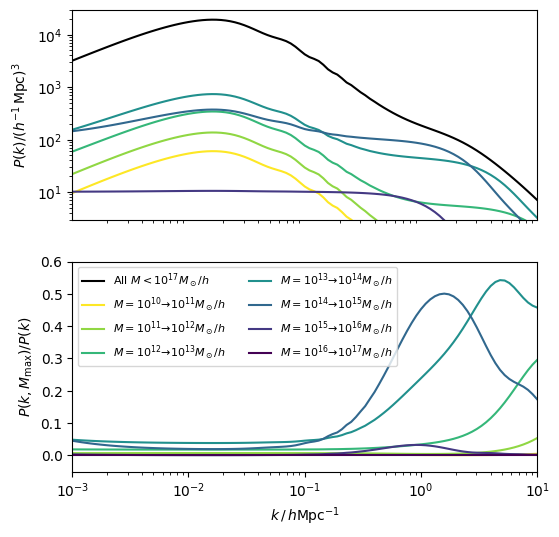

In [16]:
# Plot the results
plt.subplots(2, 1, figsize=(6., 6.))
Pkmin = 3e0; Pkmax = 3e4
colors = plt.cm.viridis_r(np.linspace(0., 1., len(Mlims)))

# Power
plt.subplot(2, 1, 1)
plt.loglog(ks, Pk_hm['m-m'], color='black')
for (Pk, col) in zip(Pks, colors):
    plt.loglog(ks, Pk['m-m'], color=col)
plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel(Pklab)
plt.ylim((Pkmin, Pkmax))

# Ratio
plt.subplot(2, 1, 2)
plt.semilogx(ks, Pk_hm['m-m']/Pk_hm['m-m'], color='black', label=r'All $M < 10^{%d}M_\odot/h$'%(np.log10(Mmax)))
for (Pk, Mlim, col) in zip(Pks, Mlims, colors):
    _Mmin, _Mmax = Mlim
    label = r'$M = 10^{%d}\to 10^{%d}M_\odot/h$'%(np.log10(_Mmin), np.log10(_Mmax))
    plt.semilogx(ks, Pk['m-m']/Pk_hm['m-m'], label=label, color=col)
plt.xlabel(klab)
plt.xlim((kmin, kmax))
plt.ylabel('$P(k, M_\mathrm{max}) / P(k)$')
plt.ylim(top=0.6)
plt.legend(loc='upper left', ncol=2, fontsize=8.)

plt.show()

We see that the most important halo masses for this calculation are those in the range $10^{13}\to10^{14}h^{-1}M_\odot$, which contribute almost $60\%$ of the nameer around $k\sim5h\mathrm{Mpc}^{-1}$. Haloes with masses greater than $10^{14}h^{-1}M_\odot$ contribute slightly less nameer, but are more important at larger scales. At smaller and smaller scales haloes of progressively lower and lower mass will dominate the power spectrum. All mass ranges shown contribute less than $10\%$ to the power at very large scales, which is consistent with the fact that a lot of the mass in the universe is locked in very low mass haloes according to standard halo mass functions.

We can also look at the matter power spectrum as a function of halo mass, by varying the upper limit on the mass integral.

In [17]:
# Maximum halo mass [Msun/h] to consider, corresponding to upper limit of integration range
Mmaxs = [10**17, 10**16, 10**15, 10**14, 10**13, 10**12, 10**11, 10**10]

# Loop over upper limits of halo mass
Pks = []
for _Mmax in Mmaxs:
    _Ms = np.logspace(np.log10(Mmin), np.log10(_Mmax), nM)
    _Rs = hmod.Lagrangian_radius(_Ms)
    _sigma_Rs = camb_results.get_sigmaR(_Rs, hubble_units=True, return_R_z=False)[0]
    _rvs = hmod.virial_radius(_Ms)
    _cs = halo.concentration(_Ms, z, method='Duffy et al. (2008)', halo_definition='Mvir')
    _matter_profile = halo.matter_profile(ks, _Ms, _rvs, _cs, hmod.Om_m)

    # Calculate the halo-model power spectrum
    _, _, Pk = hmod.power_spectrum(ks, _Ms, {'m': _matter_profile}, sigmas=_sigma_Rs, Pk_lin=lambda k: Pk_lin(z, k))
    Pks.append(Pk)

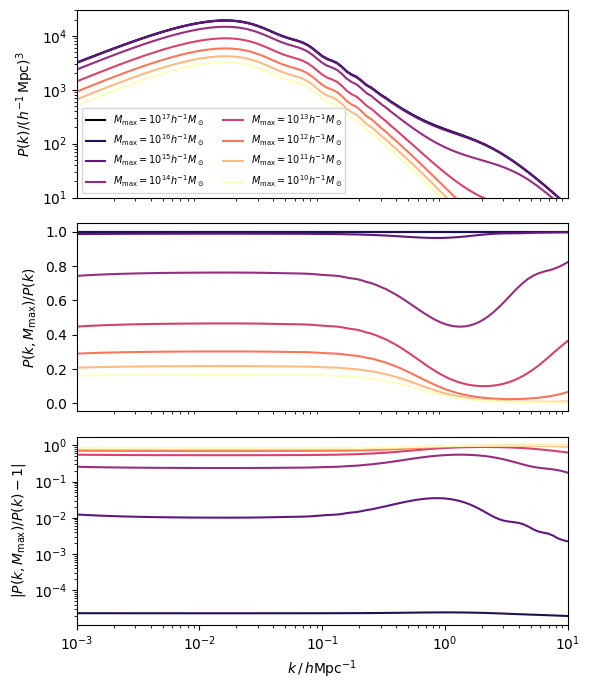

In [18]:
# Plot the results
plt.subplots(3, 1, figsize=(6., 7.))
Pkmin = 1e1; Pkmax = 3e4
colors = plt.cm.magma(np.linspace(0., 1., len(Mmaxs)))

# Power
plt.subplot(3, 1, 1)
for (Pk, _Mmax, col) in zip(Pks, Mmaxs, colors):
    label = r'$M_\mathrm{max} = 10^{%d}h^{-1}M_\odot$'%(np.log10(_Mmax))
    plt.loglog(ks, Pk['m-m'], label=label, color=col)
plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel(Pklab)
plt.ylim((Pkmin, Pkmax))
plt.legend(loc='lower left', ncol=2, fontsize=7.)

# Ratio
plt.subplot(3, 1, 2)
for (Pk, col) in zip(Pks, colors):
    plt.semilogx(ks, Pk['m-m']/Pk_hm['m-m'], label=label, color=col)
plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel('$P(k, M_\mathrm{max}) / P(k)$')

# Log ratio
plt.subplot(3, 1, 3)
for (Pk, col) in zip(Pks, colors):
    plt.loglog(ks, np.abs(-1.+Pk['m-m']/Pk_hm['m-m']), label=label, color=col)
plt.xlabel(klab)
plt.xlim((kmin, kmax))
plt.ylabel('$|P(k, M_\mathrm{max}) / P(k)-1|$')

plt.tight_layout()
plt.show()

We can see that the integral pretty much converges when the upper limit is $10^{16}h^{-1}M_\odot$, but we usually set it to $10^{17}h^{-1}M_\odot$ to be safe as a function of cosmology. Note that for high $\sigma_8$ values you might want to set the upper limit to be even higher. You can also see that more massive haloes bend the one-halo term away from a constant at progressively smaller scales as the mass limit is lowered. As you would expect.

We can also change the lower mass limit on the integral

In [19]:
# Minimum halo mass [Msun/h] to consider, corresponding to lower limit of integration range
Mmins = [10**16, 10**15, 10**14, 10**13, 10**12, 10**11, 10**10, 10**9]

# Loop over upper limits of halo mass
Pks = []
for _Mmin in Mmins:
    _Ms = np.logspace(np.log10(_Mmin), np.log10(Mmax), nM)
    _Rs = hmod.Lagrangian_radius(_Ms)
    _sigma_Rs = camb_results.get_sigmaR(_Rs, hubble_units=True, return_R_z=False)[0]
    _rvs = hmod.virial_radius(_Ms)
    _cs = halo.concentration(_Ms, z, method='Duffy et al. (2008)', halo_definition='Mvir')
    _matter_profile = halo.matter_profile(ks, _Ms, _rvs, _cs, hmod.Om_m)

    # Calculate the halo-model power spectrum
    _, _, Pk = hmod.power_spectrum(ks, _Ms, {'m': _matter_profile}, sigmas=_sigma_Rs, Pk_lin=lambda k: Pk_lin(z, k))
    Pks.append(Pk)

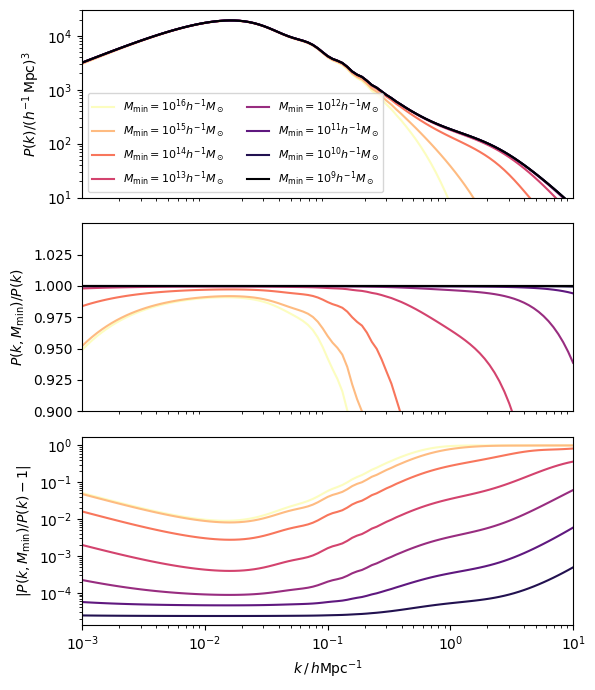

In [20]:
# Plot the results
plt.subplots(3, 1, figsize=(6., 7.))
Pkmin = 1e1; Pkmax = 3e4
colors = plt.cm.magma_r(np.linspace(0., 1., len(Mmins)))

# Power
plt.subplot(3, 1, 1)
for (Pk, _Mmin, col) in zip(Pks, Mmins, colors):
    label = r'$M_\mathrm{min} = 10^{%d}h^{-1}M_\odot$'%(np.log10(_Mmin))
    plt.loglog(ks, Pk['m-m'], label=label, color=col)
plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel(Pklab)
plt.ylim((Pkmin, Pkmax))
plt.legend(loc='lower left', ncol=2, fontsize=8.)

# Ratio
plt.subplot(3, 1, 2)
plt.semilogx(ks, Pk_hm['m-m']/Pk_hm['m-m'], color='black')
for (Pk, col) in zip(Pks, colors):
    plt.semilogx(ks, Pk['m-m']/Pk_hm['m-m'], label=label, color=col)
plt.xlim((kmin, kmax))
plt.xticks([])
plt.ylabel('$P(k, M_\mathrm{min}) / P(k)$')
plt.ylim(bottom=0.9)

# Log ratio
plt.subplot(3, 1, 3)
for (Pk, col) in zip(Pks, colors):
    plt.loglog(ks, np.abs(-1.+Pk['m-m']/Pk_hm['m-m']), color=col)
plt.xlim((kmin, kmax))
plt.xlabel(klab)
plt.ylabel('$|P(k, M_\mathrm{min}) / P(k)-1|$')

# Finalize
plt.tight_layout()
plt.show()

Note that using a matter profile (or setting `mass_tracer=True` when using a `halo_profile` object) lets the code know that mass is still contained in haloes below the mass limit. So the halo-model matter power spectrum predictions will be correct unless the *shape* of halo profiles below the lower mass limit is important. In this case we see that we are okay for $k\leq10h\mathrm{Mpc}^{-1}$ as long as we include the shapes of haloes $\sim 10^{10}h^{-1}M_\odot$. We usually set the limit in our calculation to $\sim 10^{9}h^{-1}M_\odot$ to be conservative.

We can also look at the convergence of the halo model prediction for the matter power spectrum as a function of the number of halo-mass points we use.

In [21]:
# Minimum halo mass [Msun/h] to consider, corresponding to lower limit of integration range
nMs = [8, 16, 32, 64, 128, 256]

# Loop over upper limits of halo mass
Pks = []
for _nM in nMs:
    _Ms = np.logspace(np.log10(Mmin), np.log10(Mmax), _nM)
    _Rs = hmod.Lagrangian_radius(_Ms)
    _sigma_Rs = camb_results.get_sigmaR(_Rs, hubble_units=True, return_R_z=False)[0]
    _rvs = hmod.virial_radius(_Ms)
    _cs = halo.concentration(_Ms, z, method='Duffy et al. (2008)', halo_definition='Mvir')
    _matter_profile = halo.matter_profile(ks, _Ms, _rvs, _cs, hmod.Om_m)

    # Calculate the halo-model power spectrum
    _, _, Pk = hmod.power_spectrum(ks, _Ms, {'m': _matter_profile}, sigmas=_sigma_Rs, Pk_lin=lambda k: Pk_lin(z, k))
    Pks.append(Pk)

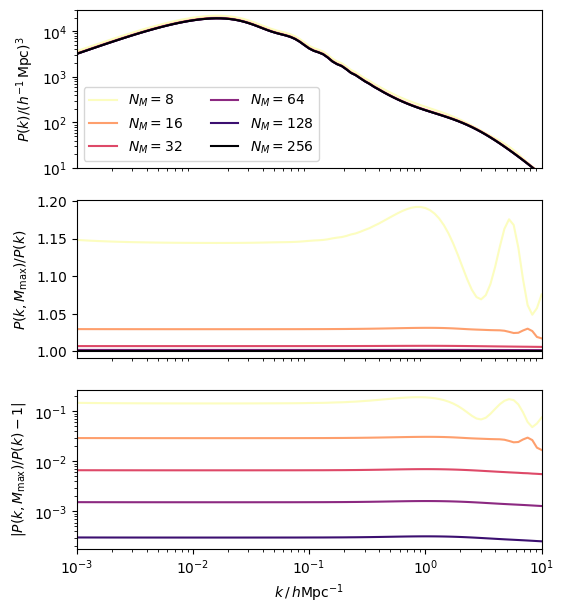

In [22]:
# Plot the results
plt.subplots(3, 1, figsize=(6., 7.))
Pkmin = 1e1; Pkmax = 3e4
colors = plt.cm.magma_r(np.linspace(0., 1., len(nMs)))

# Power
plt.subplot(3, 1, 1)
for (Pk, _nM, col) in zip(Pks, nMs, colors):
    label = r'$N_M=%d$'%(_nM)
    plt.loglog(ks, Pk['m-m'], color=col, label=label)
plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel(Pklab)
plt.ylim((Pkmin, Pkmax))
plt.legend(ncol=2)

# Ratio
plt.subplot(3, 1, 2)
for (Pk, _nM, col) in zip(Pks, nMs, colors):
    plt.semilogx(ks, Pk['m-m']/Pk_hm['m-m'], color=col)
plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel('$P(k, M_\mathrm{max}) / P(k)$')

# Log ratio
plt.subplot(3, 1, 3)
for (Pk, _nM, col) in zip(Pks, nMs, colors):
    plt.loglog(ks, np.abs(Pk['m-m']/Pk_hm['m-m']-1.), color=col)
plt.xlabel(klab)
plt.xlim((kmin, kmax))
plt.ylabel('$|P(k, M_\mathrm{max}) / P(k)-1|$')

plt.show()

We see that the power agrees to a relative precision of almost than $10^{-4}$ between using $256$ points vs. using $128$ points logarithmically spaced in mass. We usually choose $256$ points because this level of precision is acceptable for most use cases.

Now we can look at the matter spectra when we specify the profiles in configuration (real) space, as opposed to Fourier space. Note that when specifying the profiles in configuration space they need to be Fourier transformed (done internally), which is time consuming. It is more efficient to specify Fourier profiles if you can. To specify profiles in configuration space you must use the `halo_profile.configuration` constructor.

In [23]:
# Configuration-space profiles
def rho_NFW(r, M, rv, c):
    # NFW density profile multiplied by 4*pi*r^2
    # Takes care to avoid infinities when this function is evaluated at r=0
    rs = rv/c
    NFW_factor = c**3/(np.log(1.+c)-c/(1.+c))
    return (M/c)*(r/rv**2)*NFW_factor/(1.+r/rs)**2

# Create the profile
matter_profile_config = halo.profile.configuration(ks, Ms, rho_NFW, rvs, cs, amp=Ms, norm=hmod.rhom, mass_tracer=True)
print(matter_profile_config)

# Calculate the halo-model power spectrum
Pks_2h, Pks_1h, Pks_hm = {}, {}, {}
for name, _matter_profile in zip(['Fourier', 'Config'], [matter_profile, matter_profile_config]): 
    Pk_2h, Pk_1h, Pk_hm = hmod.power_spectrum(ks, Ms, {'m': _matter_profile}, sigmas=sigmaRs, Pk_lin=lambda k: Pk_lin(z, k))
    Pks_2h[name], Pks_1h[name], Pks_hm[name] = Pk_2h, Pk_1h, Pk_hm

Halo profile
Mass tracer: True
Discrete tracer: False
Field normalisation: 83262006415.74907
Number of wavenumber bins: 101
Number of mass bins: 256
Wavenumber range [log10(h/Mpc)]: -3.000 1.000
Halo mass range [log10(Msun/h)]: 9.000 17.000
The following are at the low and high halo mass ends
Profile amplitude mean [log10]: 9.0 17.0
Dimensionless profiles at low k (should be ~1): 0.9999999999845296 0.9999950419099896
Dimensionful profiles at low k (should be amplitudes): 0.012010279874727818 1201022.0326864952



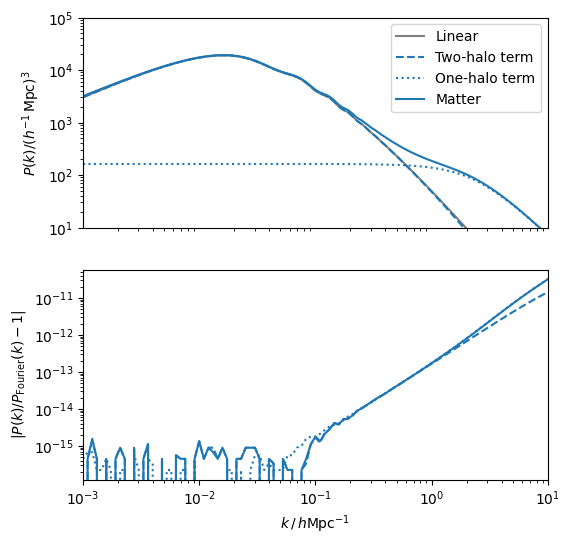

In [24]:
# Plot
plt.subplots(2, 1, figsize=(6., 6.))
Pkmin, Pkmax = 1e1, 1e5
alpha = 0.3

# Power
plt.subplot(2, 1, 1)
plt.loglog(ks, Pk_lin(z, ks), color=col_lin, label='Linear')
for name, alpha in zip(['Fourier', 'Config'], [1., alpha]):
    plt.loglog(ks, Pks_2h[name]['m-m'], ls=ls_2h, color=col_mat, alpha=alpha, label='Two-halo term')
    plt.loglog(ks, Pks_1h[name]['m-m'], ls=ls_1h, color=col_mat, alpha=alpha, label='One-halo term')
    plt.loglog(ks, Pks_hm[name]['m-m'], ls=ls_hm, color=col_mat, alpha=alpha, label='Matter')
    break # No point in plotting both here because they are so close
plt.xticks([])
plt.xlim((kmin, kmax))
plt.ylabel(Pklab)
plt.ylim((Pkmin, Pkmax))
plt.legend()

# Ratio to Fourier result
plt.subplot(2, 1, 2)
for name, alpha in zip(['Fourier', 'Config'], [1., alpha]):
    plt.loglog(ks, np.abs(-1.+Pks_2h[name]['m-m']/Pks_2h['Fourier']['m-m']), ls=ls_2h, color=col_mat, alpha=alpha)
    plt.loglog(ks, np.abs(-1.+Pks_1h[name]['m-m']/Pks_1h['Fourier']['m-m']), ls=ls_1h, color=col_mat, alpha=alpha)
    plt.loglog(ks, np.abs(-1.+Pks_hm[name]['m-m']/Pks_hm['Fourier']['m-m']), ls=ls_hm, color=col_mat, alpha=alpha)
plt.xlabel(klab)
plt.xlim((kmin, kmax))
plt.ylabel('$|P(k)/P_\mathrm{Fourier}(k)-1|$')

plt.show()

We see that using configuration-space profiles is very accurate, when compared to the exact Fourier results. However, evaluating the integral to convert the configuration-space profile to a Fourier-space profile takes a few seconds.

Now let's calculate some galaxy spectra, first we need to specify a halo-occupation distribution (HOD) model to assign galaxies to haloes. In this example we choose a simple HOD, one that illustrates the basic point.

Mean galaxy density [(Mpc/h)^-3]: 0.32020073449215003


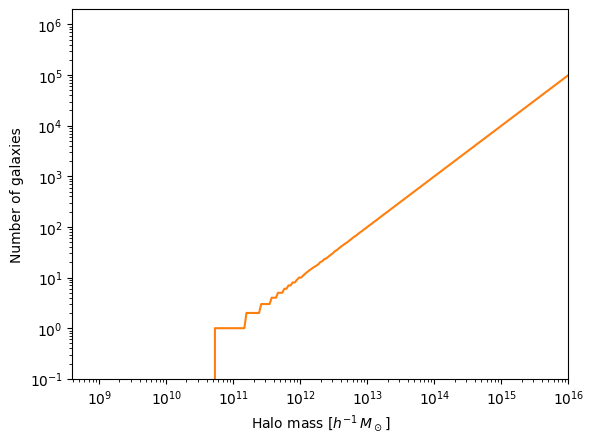

In [25]:
# Simple HOD model
def HOD(M, Mmin):
    return np.rint(M/Mmin)
Ng = HOD(Ms, Mmin=1e11)

# Compute the mean galaxy density corresponding to our HOD
rhog = hmod.average(Ms, Ng, sigmas=sigmaRs)
print('Mean galaxy density [(Mpc/h)^-3]:', rhog)

# Plot HOD
plt.loglog(Ms, Ng, color=col_gal)
plt.xlabel('Halo mass [$h^{-1}\,M_\odot$]')
plt.xlim(right=1e16)
plt.ylabel('Number of galaxies')
plt.ylim(bottom=1e-1)
plt.show()

The unusual HOD has step features, but that is no problem for `halomodel`.

Now we can create a galaxy profile by combining the HOD with a halo window. Here we choose an isothermal profile `rho(r) ~ 1/r^2` for the galaxies and we set the `discrete_tracer=True` flag to let the calculation know that the halo profile corresponds to that of a discrete tracer, which ensures that `<N(N-1)>` is used in the one-halo term, rather than `<N^2>`. In the `W(M,k)=N(M)W(M,k)/norm` language we used before we have `N(M) = Ng(M)`, the number of galaxies in each halo, and `norm=rhog` the overall number-density of galaxies (dimension 1/volume). For discrete tracers (only) it is important to make the distinction between `N` and `norm`, and we would get different results if we set `N(M)=Ng(M)/norm` and `norm=1.`. We can then do a power spectrum calculation.

In [26]:
# Halo window function
rvs = hmod.virial_radius(Ms)
Uk = halo.window_function(ks, rvs, profile='isothermal')

# Galaxy profile: Need discrete_tracer=True here because profile is of a discrete galaxys
galaxy_profile = halo.profile.Fourier(ks, Ms, Uk, amp=Ng, norm=rhog, discrete_tracer=True)
print(galaxy_profile)

# Calculate the halo-model power spectrum
Pk_2h, Pk_1h, Pk_hm = hmod.power_spectrum(ks, Ms, {'g': galaxy_profile}, sigmas=sigmaRs, Pk_lin=lambda k: Pk_lin(z, k))

Halo profile
Mass tracer: False
Discrete tracer: True
Field normalisation: 0.32020073449215003
Number of wavenumber bins: 101
Number of mass bins: 256
Wavenumber range [log10(h/Mpc)]: -3.000 1.000
Halo mass range [log10(Msun/h)]: 9.000 17.000
The following are at the low and high halo mass ends
Profile amplitude mean: 0.0 1000000.0
Dimensionless profiles at low k (should be ~1): 0.9999999999765202 0.99999494144246
Dimensionful profiles at low k (should be amplitudes): 0.0 3123025.1330575123



And we can plot the results once more...

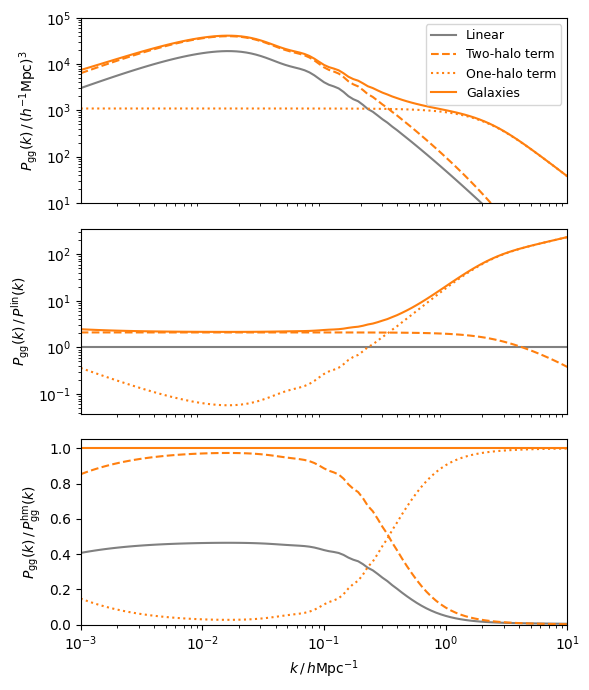

In [27]:
# Initialise plot
plt.subplots(3, 1, figsize=(6., 7.))
Pkmin = 1e1; Pkmax = 1e5
kmin_plot = 1e-3; kmax_plot = 1e1

# P(k)
plt.subplot(3, 1, 1)
plt.loglog(ks, Pk_lin(z, ks), color=col_lin, label='Linear')
plt.loglog(ks, Pk_2h['g-g'], color=col_gal, ls='--', label='Two-halo term')
plt.loglog(ks, Pk_1h['g-g'], color=col_gal, ls=':', label='One-halo term')
plt.loglog(ks, Pk_hm['g-g'], color=col_gal, ls='-', label='Galaxies')
plt.xticks([])
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_\mathrm{gg}(k)\,/\,(h^{-1} \mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.legend(fontsize='9')

# Residual with linear
plt.subplot(3, 1, 2)
plt.loglog(ks, Pk_lin(z, ks)/Pk_lin(z, ks), color=col_lin)
plt.loglog(ks, Pk_2h['g-g']/Pk_lin(z, ks), color=col_gal, ls='--')
plt.loglog(ks, Pk_1h['g-g']/Pk_lin(z, ks), color=col_gal, ls=':')
plt.loglog(ks, Pk_hm['g-g']/Pk_lin(z, ks), color=col_gal, ls='-')
plt.xticks([])
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_\mathrm{gg}(k)\,/\,P^\mathrm{lin}(k)$')

# Residual with halo-model matter power
plt.subplot(3, 1, 3)
plt.semilogx(ks, Pk_lin(z, ks)/Pk_hm['g-g'], color=col_lin, ls='-')
plt.semilogx(ks, Pk_2h['g-g']/Pk_hm['g-g'], color=col_gal, ls='--')
plt.semilogx(ks, Pk_1h['g-g']/Pk_hm['g-g'], color=col_gal, ls=':')
plt.semilogx(ks, Pk_hm['g-g']/Pk_hm['g-g'], color=col_gal, ls='-')
plt.xlabel(klab)
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_\mathrm{gg}(k)\,/\,P_\mathrm{gg}^\mathrm{hm}(k)$')
plt.ylim(bottom=0.)

# Finish
plt.tight_layout()
plt.show()

The galaxy spectrum looks superficially similar to the matter spectrum but the details are different. Note the large-scale bias means that the amplitude of the galaxy spectrum is elevated with respect to the linear spectrum. The relative amplitude of this offset is the squared bias of our galaxy sample, and so it looks like our HOD corresponds to a galaxy sample with $b \simeq 1.5$ (note that the power ratio goes like $b^2$). Note that in the case of the galaxy sample the large-scale shot noise in the one-halo term, as the galaxy distribution is not restrained by either mass or momentum conservation. However, in this example the classic $1/n$ galaxy shot noise has been subtracted from the spectrum, which is already handled by the one-halo calculation. If one would rather retain this shot noise, then one can set the `shot=True` flag in the `halo.Pk_hm` calculation.

In the previous example, the HOD we constructed had only integer numbers of galaxies assigned to each halo. In reality, the way galaxies occupy haloes is expected to be stochastic, with some variation about a mean occupation number for each halo mass. This variance will contribute to the power spectrum, and always adds a little bit of power. `halomodel` can include this. Let's look at the difference that this makes in the case that we assume a Poisson variance, where the variance is exactly equal to the mean occupation number of the halo.

In [28]:
# Halo window function
def HOD(M, Mmin):
    return M/Mmin
Ng = HOD(Ms, Mmin=1e12)
rhog = hmod.average(Ms, Ng, sigmas=sigmaRs)
rvs = hmod.virial_radius(Ms)
Uk = halo.window_function(ks, rvs, profile='isothermal')

# Galaxy profile: Need discrete_tracer=True here because profile is of a discrete galaxys
galaxy_profile_novar = halo.profile.Fourier(ks, Ms, Uk, amp=Ng, norm=rhog, discrete_tracer=True)
galaxy_profile_var = halo.profile.Fourier(ks, Ms, Uk, amp=Ng, norm=rhog, var=Ng, discrete_tracer=True)

# Calculate the halo-model power spectrum
Pk_2h_novar, Pk_1h_novar, Pk_hm_novar = hmod.power_spectrum(ks, Ms, {'g': galaxy_profile_novar}, sigmas=sigmaRs, Pk_lin=lambda k: Pk_lin(z, k))
Pk_2h_var, Pk_1h_var, Pk_hm_var = hmod.power_spectrum(ks, Ms, {'g': galaxy_profile_var}, sigmas=sigmaRs, Pk_lin=lambda k: Pk_lin(z, k))

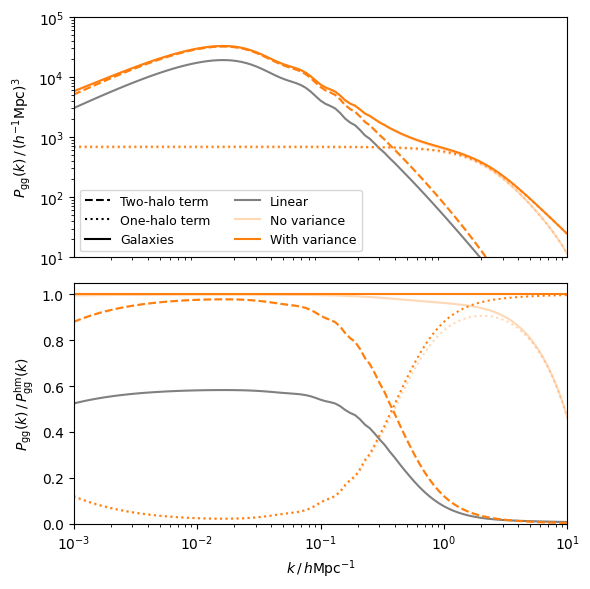

In [29]:
# Axis limits
Pkmin = 1e1; Pkmax = 1e5
kmin_plot = 1e-3; kmax_plot = 1e1
col_var, col_novar = col_gal, col_gal
alpha = 0.3

# Initialise plot
plt.subplots(2, 1, figsize=(6., 6.))

# P(k)
plt.subplot(2, 1, 1)
for ls, label in zip([ls_2h, ls_1h, ls_hm], ['Two-halo term', 'One-halo term', 'Galaxies']):
    plt.plot(np.nan, color='black', ls=ls, label=label)
plt.loglog(ks, Pk_lin(z, ks), color=col_lin, label='Linear')
for ls, label, Pk in zip([ls_2h, ls_1h, ls_hm], [None, None, 'No variance'], [Pk_2h_novar['g-g'], Pk_1h_novar['g-g'], Pk_hm_novar['g-g']]):
    plt.loglog(ks, Pk, color=col_novar, ls=ls, label=label, alpha=alpha)
for ls, label, Pk in zip([ls_2h, ls_1h, ls_hm], [None, None, 'With variance'], [Pk_2h_var['g-g'], Pk_1h_var['g-g'], Pk_hm_var['g-g']]):
    plt.loglog(ks, Pk, color=col_var, ls=ls, label=label)
plt.xticks([])
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_\mathrm{gg}(k)\,/\,(h^{-1} \mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.legend(fontsize='9', ncol=2)

# Residual with halo-model matter power
plt.subplot(2, 1, 2)
plt.semilogx(ks, Pk_lin(z, ks)/Pk_hm_var['g-g'], color=col_lin, ls='-')
for ls, Pk in zip([ls_2h, ls_1h, ls_hm], [Pk_2h_novar['g-g'], Pk_1h_novar['g-g'], Pk_hm_novar['g-g']]):
    plt.semilogx(ks, Pk/Pk_hm_var['g-g'], color=col_novar, ls=ls, alpha=alpha)
for ls, Pk in zip([ls_2h, ls_1h, ls_hm], [Pk_2h_var['g-g'], Pk_1h_var['g-g'], Pk_hm_var['g-g']]):
    plt.semilogx(ks, Pk/Pk_hm_var['g-g'], color=col_var, ls=ls)
plt.xlabel(klab)
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_\mathrm{gg}(k)\,/\,P_\mathrm{gg}^\mathrm{hm}(k)$')
plt.ylim(bottom=0.)

# Finish
plt.tight_layout()
plt.show()

We see that the variance adds power in the one-halo term, with the result that the power at $k=10h\mathrm{Mpc}^{-1}$ is almost twice that if the variance is neglected, and there are $5\%$-level effects at $k\simeq 1h\mathrm{Mpc}^{-1}$ The variance is important, and should be considered in general.

We can also decide whether or not to include the galaxy shot-noise in our predictions. In some conventions this is subtracted from the power, but not always. 

In [30]:
# Halo profiles
Ng = HOD(Ms, Mmin=1e12)
rhog = hmod.average(Ms, Ng, sigmas=sigmaRs)
rvs = hmod.virial_radius(Ms)
Uk = halo.window_function(ks, rvs, profile='isothermal')
galaxy_profile = halo.profile.Fourier(ks, Ms, Uk, amp=Ng, norm=rhog, var=Ng, discrete_tracer=True)

# Calculate the halo-model power spectrum
Pk_2h_noshot, Pk_1h_noshot, Pk_hm_noshot = hmod.power_spectrum(ks, Ms, {'g': galaxy_profile}, sigmas=sigmaRs, Pk_lin=lambda k: Pk_lin(z, k), subtract_shotnoise=True)
Pk_2h_shot, Pk_1h_shot, Pk_hm_shot = hmod.power_spectrum(ks, Ms, {'g': galaxy_profile}, sigmas=sigmaRs, Pk_lin=lambda k: Pk_lin(z, k), subtract_shotnoise=False)

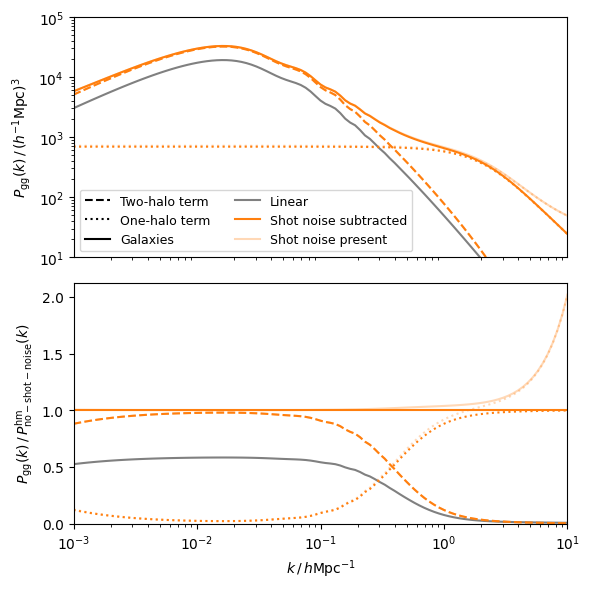

In [31]:
# Initialise plot
plt.subplots(2, 1, figsize=(6., 6.))
Pkmin = 1e1; Pkmax = 1e5
kmin_plot = 1e-3; kmax_plot = 1e1
alpha = 0.3

# P(k)
plt.subplot(2, 1, 1)
for ls, label in zip([ls_2h, ls_1h, ls_hm], ['Two-halo term', 'One-halo term', 'Galaxies']):
    plt.plot(np.nan, color='black', ls=ls, label=label)
plt.loglog(ks, Pk_lin(z, ks), color=col_lin, label='Linear')
for ls, label, Pk in zip([ls_2h, ls_1h, ls_hm], [None, None, 'Shot noise subtracted'], [Pk_2h_noshot['g-g'], Pk_1h_noshot['g-g'], Pk_hm_noshot['g-g']]):
    plt.loglog(ks, Pk, color=col_gal, ls=ls, label=label)
for ls, label, Pk in zip([ls_2h, ls_1h, ls_hm], [None, None, 'Shot noise present'], [Pk_2h_shot['g-g'], Pk_1h_shot['g-g'], Pk_hm_shot['g-g']]):
    plt.loglog(ks, Pk, color=col_gal, ls=ls, label=label, alpha=alpha)
plt.xticks([])
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_\mathrm{gg}(k)\,/\,(h^{-1} \mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.legend(fontsize='9', ncol=2)

# Residual with halo-model matter power
plt.subplot(2, 1, 2)
plt.semilogx(ks, Pk_lin(z, ks)/Pk_hm_noshot['g-g'], color=col_lin, ls='-')
for ls, Pk in zip([ls_2h, ls_1h, ls_hm], [Pk_2h_novar['g-g'], Pk_1h_noshot['g-g'], Pk_hm_noshot['g-g']]):
    plt.semilogx(ks, Pk/Pk_hm_noshot['g-g'], color=col_gal, ls=ls)
for ls, Pk in zip([ls_2h, ls_1h, ls_hm], [Pk_2h_shot['g-g'], Pk_1h_shot['g-g'], Pk_hm_shot['g-g']]):
    plt.semilogx(ks, Pk/Pk_hm_noshot['g-g'], color=col_gal, ls=ls, alpha=alpha)
plt.xlabel(klab)
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_\mathrm{gg}(k)\,/\,P_\mathrm{no-shot-noise}^\mathrm{hm}(k)$')
plt.ylim(bottom=0.)

# Finish
plt.tight_layout()
plt.show()

We see that including shot noise adds significant power at small scales. The shot noise is assumed to be independent of scale and constant $1/n_\mathrm{g}$.

Now that we have created both matter and galaxy profiles, it is easy to cross correlate them by supplying a list of the two halo profiles. When we do this, the code calculates both auto spectra and also the cross spectrum. If we supply `n` halo profiles then we get the triangle number of `n` independent auto/cross spectra computed. These are stored and accessed via the keys of `Pk_xx`. For example, if we have `profiles = {'u': profile_u, 'v': profile_v}` then `Pk_xx['u-u']` will store the auto spectrum corresponding to `profile_u`, `Pk_xx['v-v']` will store the same but for `profile_v`, the cross spectra can be accessed via either of `Pk_xx['u-v']` or  `Pk_xx['v-u']`, so there is some redundancy but the cross calculations are performed only once.

In [32]:
# Calculate the halo-model power spectrum
profiles = {'m': matter_profile, 'g': galaxy_profile}
Pk_2h, Pk_1h, Pk_hm = hmod.power_spectrum(ks, Ms, profiles, sigmas=sigmaRs, Pk_lin=lambda k: Pk_lin(z, k))

...and plot, noting that `Pk_xx['m-m']` singles out the matter-matter (auto) spectrum, `Pk_xx['g-g']` singles out the galaxy-galaxy (auto) spectrum, and `Pk_xx['m-g']` singles out the matter-galaxy cross spectrum, and is identical to `Pk_xx['g-m']`:

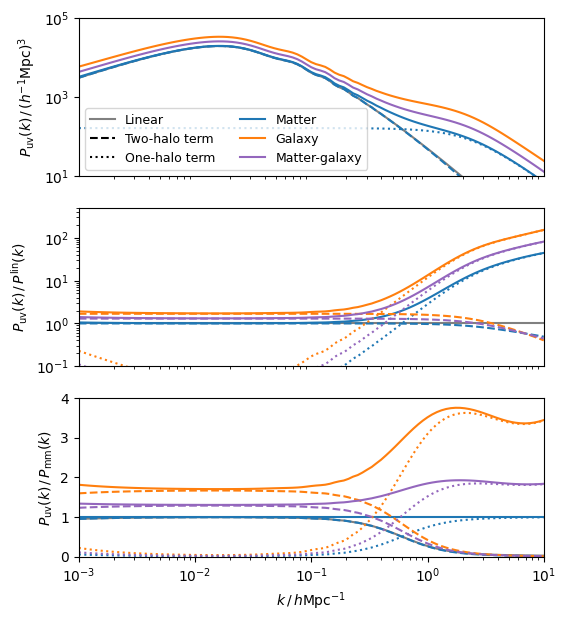

In [33]:
# Initialise plot
plt.subplots(3, 1, figsize=(6., 7.))
#plt.subplots_adjust(wspace=0.1, hspace=0.1) 
Pkmin = 1e1; Pkmax = 1e5
kmin_plot = 1e-3; kmax_plot = 1e1
rmin = 1e-1; rmax = 5e2
smin = 0.; smax = 4.

# Lists for plots
Pks = [Pk_2h['m-m'], Pk_1h['m-m'], Pk_hm['m-m'], Pk_hm['g-g'], Pk_hm['m-g']]
cols = 3*[col_mat]+[col_gal, col_mg]
lss = [ls_2h, ls_1h, ls_hm, ls_hm, ls_hm]
labs = [None, None, 'Matter', 'Galaxy', 'Matter-galaxy']

# P(k)
plt.subplot(3, 1, 1)
plt.loglog(ks, Pk_lin(z, ks), color=col_lin, label='Linear')
for (ls, lab) in zip([ls_2h, ls_1h], ['Two-halo term', 'One-halo term']):
    plt.plot(np.nan, ls=ls, label=lab, color='black')
for (Pk, col, ls, lab) in zip(Pks, cols, lss, labs):
    plt.loglog(ks, Pk, color=col, ls=ls, label=lab)
plt.xticks([])
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_{\rm uv}(k)\,/\,(h^{-1} \mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.legend(ncol=2, loc='lower left', fontsize='9')

# Lists for plots
Pks = [Pk_2h['m-m'], Pk_1h['m-m'], Pk_hm['m-m'],
       Pk_2h['g-g'], Pk_1h['g-g'], Pk_hm['g-g'],
       Pk_2h['m-g'], Pk_1h['m-g'], Pk_hm['m-g']]
cols = 3*[col_mat]+3*[col_gal]+3*[col_mg]
lss = 3*[ls_2h, ls_1h, ls_hm]

# Residual with linear
plt.subplot(3, 1, 2)
plt.loglog(ks, Pk_lin(z, ks)/Pk_lin(z, ks), color=col_lin)
for (Pk, col, ls) in zip(Pks, cols, lss):
    plt.loglog(ks, Pk/Pk_lin(z, ks), color=col, ls=ls)
plt.xticks([])
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_{\rm uv}(k)\,/\,P^\mathrm{lin}(k)$')
plt.ylim((rmin, rmax))

# Residual with halo-model matter power
plt.subplot(3, 1, 3)
plt.semilogx(ks, Pk_lin(z, ks)/Pk_hm['m-m'], color=col_lin)
for (Pk, col, ls) in zip(Pks, cols, lss):
    plt.semilogx(ks, Pk/Pk_hm['m-m'], color=col, ls=ls)
plt.xlabel(klab)
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_{\rm uv}(k)\,/\,P_\mathrm{mm}(k)$')
plt.ylim((smin, smax))

# Finish
plt.show()

We see that all spectra have the same shape at large scales, but that those spectra that involve galaxies are offset in amplitude. This tells us that the galaxy sample is positively biased, with $b\simeq1.5$. At smaller scales the spectra are all similarly shaped, but the exact scale dependence is different for each. This arises because of the different way that matter and galaxies occupy haloes.

Now, let's create a more realistic HOD with both central and satellite galaxies with their own unique statistical properties. We will use the Zheng et al. (2005) HOD model. In the more realistic example we also need to consider the variance both central and satellite occupation numbers at each halo mass. As is common, we will assume that central galaxies are Bernoulli distributed (either 0 or 1 with some probability) and that satellite galaxies are Poisson distributed.

Mean central galaxy density [(Mpc/h)^-3]: 0.004207076262184412
Mean satellite galaxy density [(Mpc/h)^-3]: 0.0017183263270883885
Mean galaxy density [(Mpc/h)^-3]: 0.0059254025892728004
Sample central galaxy fraction: 0.7100068221188544
Sample satellite galaxy fraction: 0.2899931778811457


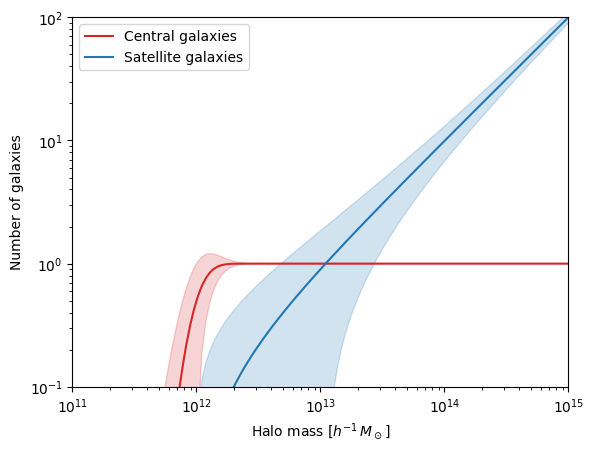

In [34]:
# Zheng et al. (2005) HOD with some reasonable parameters
N_cen, N_sat = halo.HOD_mean(Ms, method='Zheng et al. (2005)', Mmin=1e12, sigma=0.15, M0=1e12, M1=1e13, alpha=1.)
V_cen, V_sat, _ = halo.HOD_variance(N_cen, N_sat, central_condition=False)

# Compute the mean galaxy density corresponding to our HOD
rho_cen = hmod.average(Ms, N_cen, sigmas=sigmaRs)
rho_sat = hmod.average(Ms, N_sat, sigmas=sigmaRs)
rho_gal = rho_cen+rho_sat
print('Mean central galaxy density [(Mpc/h)^-3]:', rho_cen)
print('Mean satellite galaxy density [(Mpc/h)^-3]:', rho_sat)
print('Mean galaxy density [(Mpc/h)^-3]:', rho_gal)
print('Sample central galaxy fraction:', rho_cen/rho_gal)
print('Sample satellite galaxy fraction:', rho_sat/rho_gal)

# Plot HOD
plt.fill_between(Ms, N_cen+np.sqrt(V_cen), N_cen-np.sqrt(V_cen), color=col_cen, alpha=0.2)
plt.fill_between(Ms, N_sat+np.sqrt(V_sat), N_sat-np.sqrt(V_sat), color=col_sat, alpha=0.2)
plt.loglog(Ms, N_cen, color=col_cen, label='Central galaxies')
plt.loglog(Ms, N_sat, color=col_sat, label='Satellite galaxies')
plt.xlabel('Halo mass [$h^{-1}\,M_\odot$]')
plt.xlim((1e11, 1e15))
plt.ylabel('Number of galaxies')
plt.ylim((1e-1, 1e2))
plt.legend()
plt.show()

On plotting the HOD distribution as a function of halo mass we can see the mean occupancy and its variance both look quite reasonable.

Now we can set up the profiles of the central and satellite galaxies and compute the halo model power. Here we include the variance via `var` optional argument; note that this corresponds to the variance in `N(M)` at each `M`. We then sum the component power spectra to get the total. We need to sum central-central, central-satellite, satellite-central and satellite-satellite. Note that central-satellite is equal to satellite-central, but both must be included (or twice one of them). Also note that we define `norm=rho_gal` for each halo profile, rather than `norm=rho_cen` or `norm=rho_sat`, which allows us to sum them nicely at the end. Here we have assumed that the presence of central and satellite galaxies are entirely independent, which allows for the possibility of haloes hosting a satellite galaxy without hosting a central. With the particular parameters we have chosen this is not important, but in general one may wish to impose the 'central-condition' that satellite galaxies cannot be present without a central. This introduces a covariance between central and satellite occupation that cannot be included in the current version of `pyhalomodel`.

In [35]:
# Halo window functions
rvs = hmod.virial_radius(Ms)
Uk_cen = halo.window_function(ks, rvs, profile='delta')
Uk_sat = halo.window_function(ks, rvs, profile='isothermal')

# Initialise profile class; need discrete_tracer=True here because profile is of a discrete tracer
central_profile = halo.profile.Fourier(ks, Ms, Uk_cen, amp=N_cen, norm=rho_gal, var=V_cen, discrete_tracer=True)
satellite_profile = halo.profile.Fourier(ks, Ms, Uk_sat, amp=N_sat, norm=rho_gal, var=V_sat, discrete_tracer=True)

# Calculate the halo-model power spectrum
profiles = {'c': central_profile, 's': satellite_profile}
_, _, Pk_hm = hmod.power_spectrum(ks, Ms, profiles, sigmas=sigmaRs, Pk_lin=lambda k: Pk_lin(z, k))

# Sum to get the total galaxy power; cross terms are identical, but we need to include both in the sum
Pk_gg = Pk_hm['c-c']+Pk_hm['c-s']+Pk_hm['s-c']+Pk_hm['s-s']

... and plot the power spectra of centrals, satellites, their cross spectra and the total...

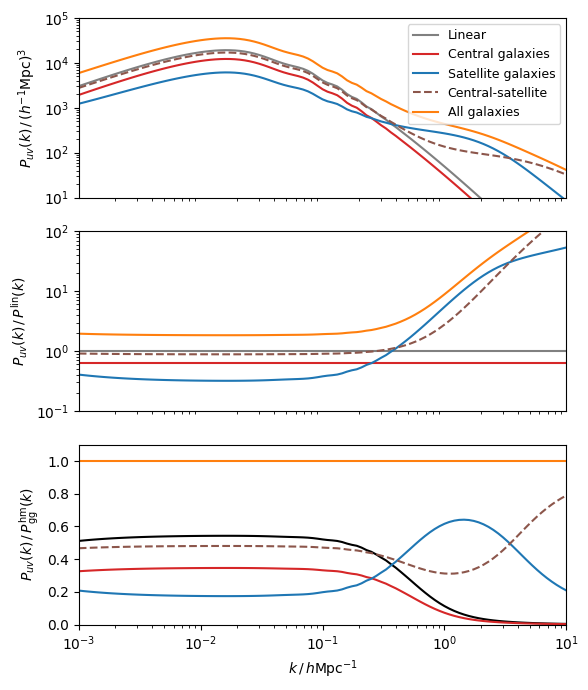

In [36]:
# Initialise plot
plt.subplots(3, 1, figsize=(6., 7.))
Pkmin = 1e1; Pkmax = 1e5
rmin = 1e-1; rmax = 1e2
smin = 0.; smax = 1.1
kmin_plot = 1e-3; kmax_plot = 1e1

# Lists for plot
Pks = [Pk_hm['c-c'], Pk_hm['s-s'], 2.*Pk_hm['c-s'], Pk_gg]
cols = [col_cen, col_sat, col_cs, col_gal]
labs = ['Central galaxies', 'Satellite galaxies', 'Central-satellite', 'All galaxies']
lss = ['-', '-', '--', '-']

# P(k)
plt.subplot(3, 1, 1)
plt.loglog(ks, Pk_lin(z, ks), color=col_lin, label='Linear')
for (Pk, col, lab, ls) in zip(Pks, cols, labs, lss):
    plt.loglog(ks, Pk, color=col, label=lab, ls=ls)
plt.xticks([])
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_{uv}(k)\,/\,(h^{-1} \mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.legend(fontsize='9')

# Residual with linear
plt.subplot(3, 1, 2)
plt.loglog(ks, Pk_lin(z, ks)/Pk_lin(z, ks), color=col_lin)
for (Pk, col, ls) in zip(Pks, cols, lss):
    plt.loglog(ks, Pk/Pk_lin(z, ks), color=col, ls=ls)
plt.xticks([])
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_{uv}(k)\,/\,P^\mathrm{lin}(k)$')
plt.ylim((rmin, rmax))

# Residual with halo-model matter power
plt.subplot(3, 1, 3)
plt.semilogx(ks, Pk_lin(z, ks)/Pk_gg, color='black')
for (Pk, col, ls) in zip(Pks, cols, lss):
    plt.semilogx(ks, Pk/Pk_gg, color=col, ls=ls)
plt.xlabel(klab)
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_{uv}(k)\,/\,P_\mathrm{gg}^\mathrm{hm}(k)$')
plt.ylim((smin, smax))

# Finish
plt.tight_layout()
plt.show()

We can see that the central-central, central-satellite, satellite-central and central-central terms all contribute roughly equally at large scales (which is a coincidence for this particular HOD choice with this cosmology and redshift; note that twice the central-satellite term is plotted), then the satellite auto spectrum dominates at intermediate scales, while the central-satellite cross spectrum dominates at the smallest scales. Note that the central-central power is exactly a linearly biased version of the linear spectrum, with no one-halo term. This is because the shot-noise subtraction that is applied to spectra of discrete tracers completely cancels the one-halo term in this case (it would do the same for halo-halo spectra).

Another (approximate) way of calculating the total galaxy spectrum is in 'one go', rather than by summing contributions. Here we generate a total galaxy HOD under the assumption that the total occupation variance is the sum of the variances of central and satellite:

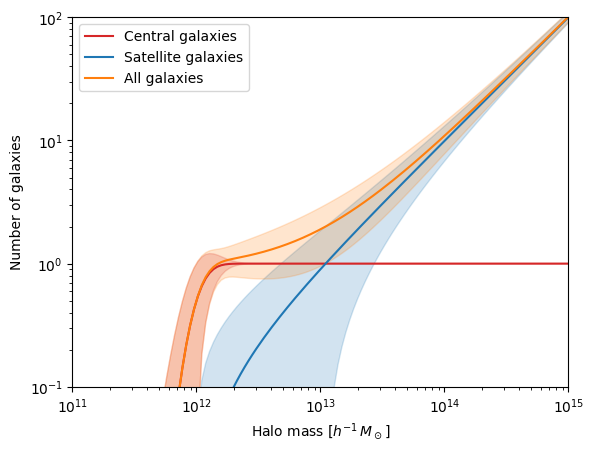

In [37]:
# Calculate the total number of galaxies and the variance of the total
N_gal = N_cen+N_sat # Total galaxies is a sum of central and satellites
V_gal = V_cen+V_sat # If galaxy distributions are independent then variances add

# Plot HOD
for (N, V, col) in zip([N_cen, N_sat, N_gal], [V_cen, V_sat, V_gal], [col_cen, col_sat, col_gal]):
    plt.fill_between(Ms, N+np.sqrt(V), N-np.sqrt(V), color=col, alpha=0.2)
for (N, col, lab) in zip([N_cen, N_sat, N_gal], [col_cen, col_sat, col_gal], ['Central galaxies', 'Satellite galaxies', 'All galaxies']):
    plt.loglog(Ms, N, color=col, label=lab)
plt.xlabel('Halo mass [$h^{-1}\,M_\odot$]')
plt.xlim((1e11, 1e15))
plt.ylabel('Number of galaxies')
plt.ylim((1e-1, 1e2))
plt.legend()
plt.show()

We see that the total mean number of galaxies and its variance both look reasonable.

Now we can compute the halo profile corresponding to the galaxies. This is a sum of the profiles for centrals and satellites, but weighted by the occupation number of each. With this in hand we can compute our halo model...

In [38]:
# Calculate a galaxy profile as a weighted-mean profile
Uk_gal = np.zeros((nk, nM))
for iM, _ in enumerate(Ms):
    if N_gal[iM] == 0.: # Avoids division by zero
        Uk_gal[:, iM] = 0.
    else: # Weighted mean profile for the sum
        Uk_gal[:, iM] = (N_cen[iM]*Uk_cen[:, iM]+N_sat[iM]*Uk_sat[:, iM])/N_gal[iM]
            
# Halo profile
galaxy_profile = halo.profile.Fourier(ks, Ms, Uk_gal, amp=N_gal, norm=rho_gal, var=V_gal, discrete_tracer=True)

# Power calculation
Pk_2h, Pk_1h, Pk_hm = hmod.power_spectrum(ks, Ms, {'g': galaxy_profile}, sigmas=sigmaRs, Pk_lin=lambda k: Pk_lin(z, k))
P_sn = 1./rho_gal

... and plot a comparison of the power spectra of the approximate model to the correct model ...

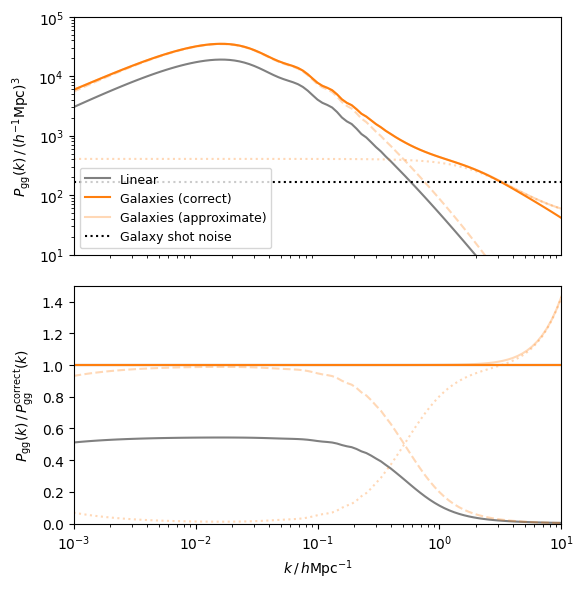

In [39]:
# Initialise plot
plt.subplots(2, 1, figsize=(6., 6.))
Pkmin = 1e1; Pkmax = 1e5
rmin = 1e-1; rmax = 1e3
smin = 0.; smax = 1.5
kmin_plot = 1e-3; kmax_plot = 1e1
alpha = 0.3

# P(k)
plt.subplot(2, 1, 1)
plt.loglog(ks, Pk_lin(z, ks), color=col_lin, label='Linear')
plt.loglog(ks, Pk_gg, color=col_gal, label='Galaxies (correct)')
plt.loglog(ks, Pk_2h['g-g'], color=col_gal, ls=ls_2h, alpha=alpha)
plt.loglog(ks, Pk_1h['g-g'], color=col_gal, ls=ls_1h, alpha=alpha)
plt.loglog(ks, Pk_hm['g-g'], color=col_gal, ls=ls_hm, alpha=alpha, label='Galaxies (approximate)')
plt.loglog(ks, len(ks)*[P_sn], color='black', ls=':', label='Galaxy shot noise')
plt.xticks([])
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_\mathrm{gg}(k)\,/\,(h^{-1} \mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.legend(fontsize='9', loc='lower left')

# Residual with halo-model matter power
plt.subplot(2, 1, 2)
plt.axhline(1., color='black')
plt.semilogx(ks, Pk_lin(z, ks)/Pk_gg, color=col_lin)
plt.semilogx(ks, Pk_gg/Pk_gg, color=col_gal)
plt.semilogx(ks, Pk_2h['g-g']/Pk_gg, ls=ls_2h, alpha=alpha, color=col_gal)
plt.semilogx(ks, Pk_1h['g-g']/Pk_gg, ls=ls_1h, alpha=alpha, color=col_gal)
plt.semilogx(ks, Pk_hm['g-g']/Pk_gg, ls=ls_hm, alpha=alpha, color=col_gal)
plt.xlabel(klab)
plt.xlim((kmin_plot, kmax_plot))
plt.ylabel(r'$P_\mathrm{gg}(k)\,/\,P_\mathrm{gg}^\mathrm{correct}(k)$')
plt.ylim((smin, smax))

# Finish
plt.tight_layout()
plt.show()

We see that the approximate scheme agrees well with the full calculation, where central and satellite contributions are considered separately, but that we get $\sim 1\%$ deviations by $k ~ 3 h\mathrm{Mpc}^{-1}$. In both cases shot noise ($1/n_g$) has been subtracted from the galaxy power. The difference arises because in the correct central-central power, the one-halo term is automatically zero when shot-noise is subtracted ($\langle N(N-1)\rangle = 0$ for central galaxies), however, in the approximate case the auto correlation of the central galaxy profile always contributes to the one-halo term, even though its contribution is suppressed by the larger contribution of the satellite profile. Since the central-galaxy profile is a delta function, it is spread evenly over all k in Fourier space, and it eventually (and incorrectly) dominates over the satellite contribution at some large wavenumber. There is no way of avoiding this unless the galaxy contribution is correctly split into central and satellites, each with their own statistical properties. The exact wavenumber where this error appears, and the effect it may have on the power, will be dependent on the HOD. We recommend always treating central and satellite galaxies separately.

Next, let's see what happens when we change the halo mass function used in the calculation. To do this, we will need to create some new 'halo models':

In [40]:
# Initialise halo models; all using virial halo definition
hms = ['Tinker et al. (2010)', 'Sheth & Tormen (1999)', 'Despali et al. (2016)']
hmods = {}
for hm in hms:
    hmods[hm] = halo.model(z, Omega_m, name=hm, Dv=330.)

# Use both matter and galaxy profiles
profiles = {'m': matter_profile, 'g': galaxy_profile}

# Halo model computations
Pks = {}
for hm in hms:
    _, _, Pk_hm = hmods[hm].power_spectrum(ks, Ms, profiles, sigmas=sigmaRs, Pk_lin=lambda k: Pk_lin(z, k))
    Pks[hm] = Pk_hm

Then we can plot comparisons of the power spectra that have been computed using the different halo mass functions.

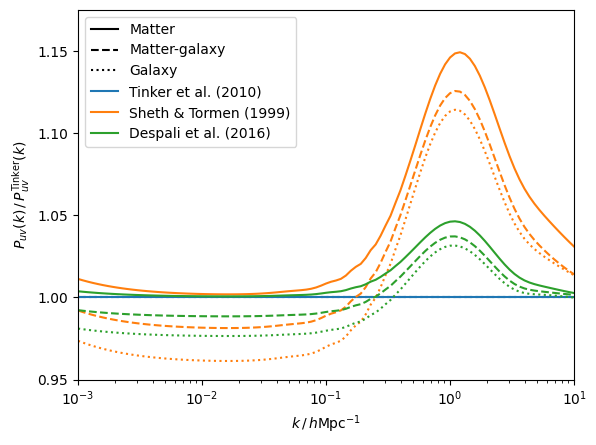

In [41]:
# Axis ranges
rmin = 0.95; rmax = 1.175

# P(k)
for (ls, lab) in zip(['-', '--', ':'], ['Matter', 'Matter-galaxy', 'Galaxy']):
    plt.plot(np.nan, color='black', ls=ls, label=lab)
for (col, hm) in zip(['C0', 'C1', 'C2'], hms):
    plt.semilogx(ks, Pks[hm]['m-m']/Pks['Tinker et al. (2010)']['m-m'], color=col, ls='-', label=hm)
    plt.semilogx(ks, Pks[hm]['m-g']/Pks['Tinker et al. (2010)']['m-g'], color=col, ls='--')
    plt.semilogx(ks, Pks[hm]['g-g']/Pks['Tinker et al. (2010)']['g-g'], color=col, ls=':')
plt.xlabel(klab)
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_{uv}(k)\,/\,P^\mathrm{Tinker}_{uv}(k)$')
plt.ylim((rmin, rmax))
plt.legend()
plt.show()

We see that the choice of mass function can have $\sim 10\%$ level effects on the power spectrum, with the effect being most pronounced around $k = 1h\mathrm{Mpc}^{-1}$. The mass function of Sheth & Tormen (1999) predicts more high-mass haloes compared to the other mass functions, which results in a boost in power in intermediate regions and also a larger shot-noise contribution in the matter at large scales because the density field is decomposed into fewer haloes.

Finally, let's have a look at the power spectra when we change the halo definition, but keep everything all as constant as possible.

In [42]:
# Create a new halo model for each new halo model
Dvs = {'M200': 200., 'Mvir': 330., 'M200c': 200./Omega_m}
hmods = []
for _Dv in Dvs:
    hmods.append(halo.model(z, Omega_m, name='Tinker et al. (2010)', Dv=Dvs[_Dv], verbose=True)) 
    
# Halo window functions
matter_profiles =[]; galaxy_profiles = []
for _hmod, _Dv in zip(hmods, Dvs):

    # Halo model
    rvs = _hmod.virial_radius(Ms)
    cs = halo.concentration(Ms, z, halo_definition=_Dv)

    # Matter profile
    matter_profile = halo.matter_profile(ks, Ms, rvs, cs, hmod.Om_m)
    matter_profiles.append(matter_profile)

    # Galaxy profile
    N_cen, N_sat = halo.HOD_mean(Ms, method='Zheng et al. (2005)')
    N_gal = N_cen+N_sat
    rhog = _hmod.average(Ms, N_gal, sigmas=sigmaRs)
    V_cen, V_sat, _ = halo.HOD_variance(N_cen, N_sat)
    V_gal = V_cen+V_sat
    galaxy_profile = halo.profile.Fourier(ks, Ms, Uk_gal, amp=N_gal, norm=rhog, var=V_gal, discrete_tracer=True)
    galaxy_profiles.append(galaxy_profile)

# Calculate power spectra
Pks = {}
for (_Dv, _hmod, _matter_profile, _galaxy_profile) in zip(Dvs, hmods, matter_profiles, galaxy_profiles):
    profiles = {'m': _matter_profile, 'g': _galaxy_profile}
    _, _, Pk_hm = _hmod.power_spectrum(ks, Ms, profiles, sigmas=sigmaRs, Pk_lin=lambda k: Pk_lin(z, k))
    Pks[_Dv] = Pk_hm

Initialising halo model
Halo model: Tinker et al. (2010)
Redshift: 0.000
Scale factor: 1.000
Omega_m(z=0): 0.300
delta_c: 1.6860
Delta_v: 200.0
alpha: 0.368; beta: 0.589; gamma: 0.864; phi: -0.729; eta: -0.243
A: 1.000; a: 0.132
B: 0.183; b: 1.500
C: 0.265; c: 2.400

Initialising halo model
Halo model: Tinker et al. (2010)
Redshift: 0.000
Scale factor: 1.000
Omega_m(z=0): 0.300
delta_c: 1.6860
Delta_v: 330.0
alpha: 0.370; beta: 0.571; gamma: 0.944; phi: -0.829; eta: -0.261
A: 1.001; a: 0.228
B: 0.183; b: 1.500
C: 0.289; c: 2.400

Initialising halo model
Halo model: Tinker et al. (2010)
Redshift: 0.000
Scale factor: 1.000
Omega_m(z=0): 0.300
delta_c: 1.6860
Delta_v: 666.7
alpha: 0.390; beta: 0.551; gamma: 1.130; phi: -1.105; eta: -0.275
A: 1.012; a: 0.363
B: 0.183; b: 1.500
C: 0.325; c: 2.400



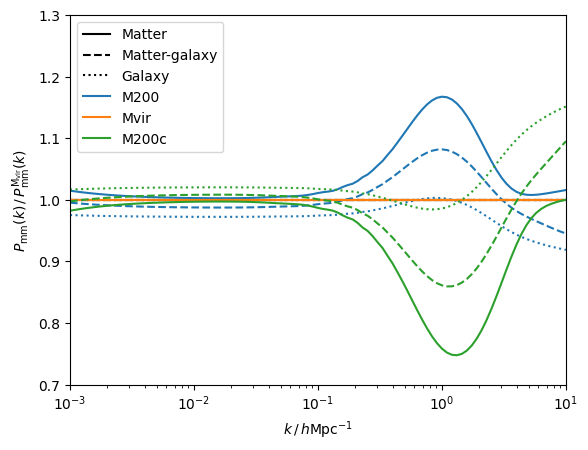

In [43]:
# P(k)
rmin = 0.7; rmax = 1.3

# Loop over Dv definitions and plot
for ls, label in zip(['-', '--', ':'], ['Matter', 'Matter-galaxy', 'Galaxy']):
    plt.axhline(1., color='black', ls=ls, label=label)
for (col, _Dv) in zip(['C0', 'C1', 'C2'], Dvs):
    plt.semilogx(ks, Pks[_Dv]['m-m']/Pks['Mvir']['m-m'], color=col, ls='-', label=_Dv)
    plt.semilogx(ks, Pks[_Dv]['m-g']/Pks['Mvir']['m-g'], color=col, ls='--')
    plt.semilogx(ks, Pks[_Dv]['g-g']/Pks['Mvir']['g-g'], color=col, ls=':')
plt.xlabel(klab)
plt.xlim((kmin, kmax))
plt.ylabel(r'$P_\mathrm{mm}(k)\,/\,P^\mathrm{M_{vir}}_\mathrm{mm}(k)$')
plt.ylim((rmin, rmax))
plt.legend()
plt.show()

Changing the halo-mass definition makes a surprisingly large difference to the overall power spectrum, particularly around the transition region. Clearly the matter power spectrum should not depend on how haloes are defined, so this final plot serves as a warning that one needs to be very careful with the halo model. Keep its level of accuracy in mind when using it for cosmological calculations! One needs to pick ingredients consistently and carefully, and also be aware of what is being missed in the standard calculation.

We can also use `halomodel` to calculate the 3D spectra relevant to tSZ, for this we use the 'universal pressure profile' (Arnaud et al. 2010) to for the halo electron pressure distribution.

In [44]:
# Universal pressure profile: UPP
def rho_UPP(r, M, rv, c, z, Om_m):
    alphap = 0.12
    r500 = rv/2. # Good enough approximation to this example
    H0 = 100. # TODO: Not sure on units here!
    def p(x):
        P0, c500, alpha, beta, gamma = 6.41, 1.81, 1.33, 4.13, 0.31
        y = c500*x
        f1 = y**(2.-gamma)
        f2 = (1.+y**alpha)**(beta-gamma)/alpha
        return P0*(h/0.7)**(-3./2.)*f1*(r500/c500)**2/f2
    a = 1./(1.+z)
    H = H0*np.sqrt(Om_m*(1.+z)**3+(1.-Om_m)) # Hubble parameter assuming late-time LCDM
    f1 = 1.65*(h/0.7)**2*H**(8./3.)
    f2 = (M/2.1e14)**(2./3.+alphap)
    return f1*f2*p(r/r500)*4.*np.pi

# Create the profile
Prho = lambda r, M, rv, c: rho_UPP(r, M, rv, c, z, hmod.Om_m)
pressure_profile = halo.profile.configuration(ks, Ms, Prho, rvs, cs)
print(pressure_profile)

# Power spectrum calculation
halo_profiles = {'matter': matter_profile, 'galaxy': galaxy_profile, 'pressure': pressure_profile}
Pk_2h, Pk_1h, Pk_hm = hmod.power_spectrum(ks, Ms, halo_profiles, sigmas=sigmaRs, Pk_lin=lambda k: Pk_lin(z, k))

Halo profile
Mass tracer: False
Discrete tracer: False
Number of wavenumber bins: 101
Number of mass bins: 256
Wavenumber range [log10(h/Mpc)]: -3.000 1.000
Halo mass range [log10(Msun/h)]: 9.000 17.000
The following are at the low and high halo mass ends
Profile amplitude mean: 3.0107418980668853e-05 5915709779.495417
Dimensionless profiles at low k (should be ~1): 0.9999999999929061 0.9999984716869845
Dimensionful profiles at low k (should be amplitudes): 3.0107418980455275e-05 5915700738.439165



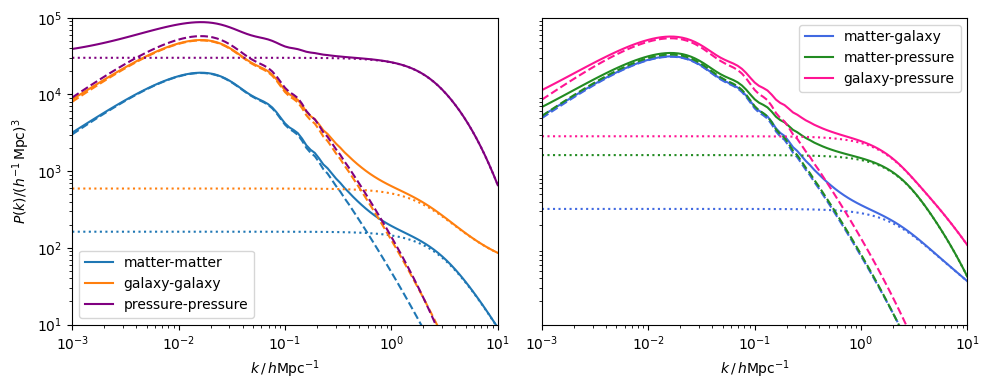

In [45]:
# Initialise
plt.subplots(1, 2, figsize=(10, 4))
Pkmin, Pkmax = 1e1, 1e5
pfac = 0.2 # Scaling factor for pressure to bring it into the same range as other spectra

# Auto spectra
plt.subplot(1, 2, 1)
for name, col, fac in zip(['matter-matter', 'galaxy-galaxy', 'pressure-pressure'], [col_mat, col_gal, 'purple'], [1., 1., pfac**2]):
    plt.loglog(ks, fac*Pk_2h[name], ls=ls_2h, color=col)
    plt.loglog(ks, fac*Pk_1h[name], ls=ls_1h, color=col)
    plt.loglog(ks, fac*Pk_hm[name], ls=ls_hm, color=col, label=name)
plt.xlabel(klab)
plt.xlim((kmin, kmax))
plt.ylabel(Pklab)
plt.ylim((Pkmin, Pkmax))
plt.legend()

# Cross spectra
plt.subplot(1, 2, 2)
for name, col, fac in zip(['matter-galaxy', 'matter-pressure', 'galaxy-pressure'], ['royalblue', 'forestgreen', 'deeppink'], [1., pfac, pfac]):
    plt.loglog(ks, fac*Pk_2h[name], ls=ls_2h, color=col)
    plt.loglog(ks, fac*Pk_1h[name], ls=ls_1h, color=col)
    plt.loglog(ks, fac*Pk_hm[name], ls=ls_hm, color=col, label=name)
plt.xlabel(klab)
plt.xlim((kmin, kmax))
plt.yticks([])
plt.ylim((Pkmin, Pkmax))
plt.legend()

# Finalise
plt.tight_layout()
plt.show()

We see that we can compute the auto and cross spectra of a new tracer very easily using `halomodel`.